In [27]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Part 1 ‐ Exploratory data analysis

In [28]:
ls

Ultimate_Technologies_challenge.ipynb  ultimate_data_challenge.json
logins.json                            ultimate_data_science_challenge.pdf


In [29]:
logins_df=pd.read_json('logins.json',convert_dates=True)

In [30]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [31]:
#create the new count column
logins_df['count'] = int(1)
#convert datetime column to index
logins_df = logins_df.set_index('login_time')

In [32]:
#resample and count
logins_df = logins_df.resample('15T').count()

logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [33]:
def fix_NaN(value):
    if np.isnan(value):
        return 0
    else:
        return value

logins_df = logins_df[['count']].applymap(func=fix_NaN) # NaN values are replaced with 0s.
logins_df['count'] = logins_df['count'].astype(int) # Ensuring counts are integers.

Will plot the 15 mins dataframe as 15*4=60 mins and  4*24=96 samples make up one complete day.The plot will have a 672 values making it a week. 

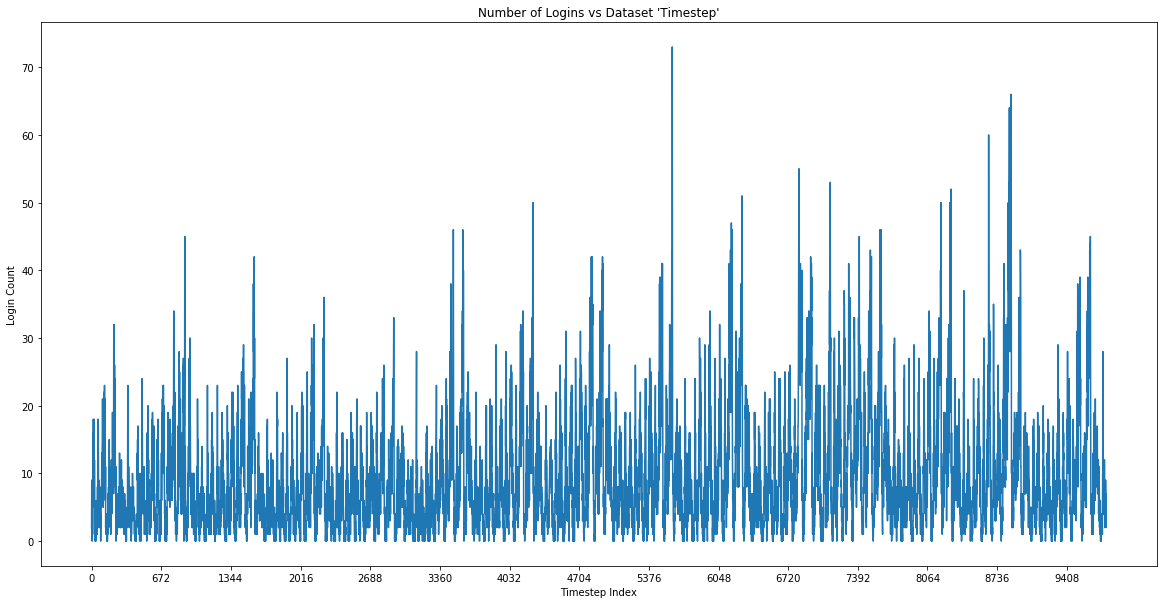

In [34]:
timesteps = logins_df.index.astype(str).values
counts = logins_df['count'].values

plt.figure(figsize=(20,10))
plt.plot(counts)
plt.title("Number of Logins vs Dataset 'Timestep'")
plt.xlabel("Timestep Index")
plt.ylabel("Login Count")
plt.xticks([x for x in range(0,len(counts),672)])
plt.show()

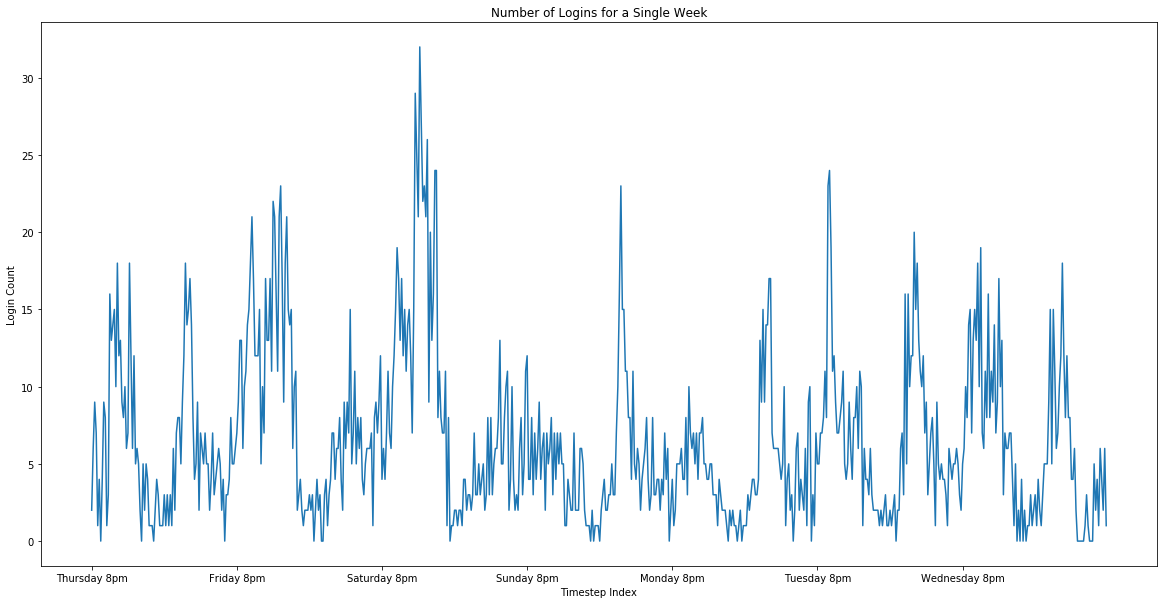

In [35]:
plt.figure(figsize=(20,10))
plt.plot(counts[0:672])
plt.title("Number of Logins for a Single Week")
plt.xlabel("Timestep Index")
plt.ylabel("Login Count")
plt.xticks([x for x in range(0,len(counts[0:672]),96)],
           ("Thursday 8pm","Friday 8pm", "Saturday 8pm", "Sunday 8pm", "Monday 8pm", "Tuesday 8pm", "Wednesday 8pm"))
plt.show()

It seems that logins tend to occur in the evenings (though sometimes there are several peaks for morning hours), stretching into the night, with maximum peak occuring on Saturday night.

Let's look at the maximum number of logins in any 15 minute window. To see exactly at what time we have the most logins.

In [36]:
print(logins_df["count"].sort_values(ascending=False)[0:30])

login_time
1970-03-01 04:30:00    73
1970-04-04 05:30:00    66
1970-04-04 01:30:00    64
1970-04-04 01:15:00    63
1970-04-01 23:30:00    60
1970-04-04 05:00:00    60
1970-04-04 05:15:00    59
1970-04-04 04:45:00    59
1970-04-04 01:45:00    56
1970-03-13 22:15:00    55
1970-04-04 01:00:00    54
1970-03-17 01:30:00    53
1970-04-04 00:30:00    53
1970-03-29 04:45:00    52
1970-03-08 04:45:00    51
1970-04-03 22:45:00    50
1970-03-29 02:15:00    50
1970-04-04 00:45:00    50
1970-02-15 04:45:00    50
1970-03-28 04:30:00    50
1970-03-01 04:45:00    48
1970-04-04 03:00:00    47
1970-03-07 03:00:00    47
1970-03-08 05:00:00    47
1970-04-03 23:15:00    47
1970-03-07 04:45:00    46
1970-04-04 03:15:00    46
1970-02-07 04:30:00    46
1970-03-22 04:00:00    46
1970-03-22 01:30:00    46
Name: count, dtype: int64


As hypothesized, we see that the peaks occur at night, but never stretch into the 'morning'

# Part 2 ‐ Experiment and metrics design

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Let us assume that a 'driving partner' is a driver for a peer-to-peer ride sharing company like Uber, Zipcar etc. Given that we are measuring success from the standpoint of city operations managers (whose job is to administer all city operations as well as to ensure maximum efficiency) we could use total revenue of all 'driver partners' for each city as the metric of success. 
"By comparing total revenue figures before and after the 'toll reimbursement' we could see a quantifiable increase in revenue". On the other hand if the aim of the city operations managers is to simply increase driver partner availability in either city,  provided we know how many partners there are in Gotham and Metropolis, then by counting the number of driver partners entering either Gotham or Metropolis at any time we would know the added availability of driver partners in both cities. 
'Number plate' scanners at the 2-way toll could be a possible way to keep track of any given driver partner's location. Suppose there are 1000 driver partners for either location, at night, when Gotham is more busy and hence there is more demand for driver partners, suppose 200 Metropolis driver partners cross the bridge to Gotham, we can see that the reimbursement increased the availability of driver partners in the location with greater demand.

  2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment b. what statistical test(s) you will conduct to verify the significance of the observation c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

# 2. 

a. The practical experiment would be to perform  A/B testing. As it is a simple and effective way to test whether the proposal to reimburse all toll costs results in more cross-city traffic. Driver partners would be selected as having 'home territory' close to the toll bridge. These groups would then be randomly divided into two groups - a control group that does not receive reimbursement, and a test group that does receive reimbursement. It will be good to run this experiment on the weekend, where there is 'reasonable activity in both cities'.

Running the experiment during the week risks a type II error. A negative result may be obtained, not because the reimbursement of tolls doesn't work, but because drivers may only work one shift a day. If so, a driver would chose to to drive either in the day or night, which would limit them to one side of the city, because there would be less business in the other side.

b. The hypotheses for this experiment are:

H0 - That reimbursement of tolls does not affect the availability of driver partners in both cities

H1 - That reimbursement of tolls does affect the availability of driver partners in both cities

Data would be recorded for pickup location and drop-off location for each driver, and the two groups then compared. To analyze the data, a simple t-test could be used to see if the distribution of cross-city pickups is significantly different for drivers who were reimbursed for tolls (test group) than those who were not reimbursed (control group).

c. Significance between the groups would indicate that reimbursing tolls does lead to greater availability of individual drivers in both cities. A caveat is that the experiment may have to be run over several weekends, in different times of the year. Factors that could influence cross-city traffic could include festivals or events in one city, or summer holidays where there are more tourists who may influence to usual cross-city traffic.

In [37]:
ls

Ultimate_Technologies_challenge.ipynb  ultimate_data_challenge.json
logins.json                            ultimate_data_science_challenge.pdf


In [40]:
ultimate_data_df=pd.read_json('ultimate_data_challenge.json')

In [41]:
ultimate_data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [42]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are some missing values in the data frame. We can impute the ratings data from the average phone with most common category.

In [43]:
by_driver_mean = ultimate_data_df.avg_rating_by_driver.mean()
of_driver_mean = ultimate_data_df.avg_rating_of_driver.mean()
print(f'Average rating of driver: {of_driver_mean:.2f}, average rating by driver: {by_driver_mean:.2f}')

Average rating of driver: 4.60, average rating by driver: 4.78


In [44]:
#Impute missing values with the average of the column
ultimate_data_df.avg_rating_by_driver.fillna(ultimate_data_df.avg_rating_by_driver.mean(),inplace=True)
ultimate_data_df.avg_rating_of_driver.fillna(ultimate_data_df.avg_rating_of_driver.mean(),inplace=True)

In [45]:
ultimate_data_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [46]:
#fill missing values with 'iPhone'
ultimate_data_df.phone.fillna(value='iPhone', inplace=True)
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [47]:

#set dtypes - datetime for dates and category for cities
ultimate_data_df.signup_date = ultimate_data_df.signup_date.astype("datetime64")
ultimate_data_df.last_trip_date = ultimate_data_df.last_trip_date.astype("datetime64")
ultimate_data_df.city = ultimate_data_df.city.astype("category")
ultimate_data_df.phone = ultimate_data_df.phone.astype("category")
ultimate_data_df.ultimate_black_user = ultimate_data_df.ultimate_black_user.astype('int')
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(6),

The instructions indicate that a user is considered retained if they were "active" in the preceeding 30 days.

In [48]:
#Will find the last date and define preceeding 30 days.
#Create a boolean column if last_trip_date falls within the preceeding defined 30 days 


In [49]:
ultimate_data_df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [50]:
cutoff_date = ultimate_data_df.last_trip_date.max() + pd.Timedelta('-30days')
cutoff_date

Timestamp('2014-06-01 00:00:00')

Users are therefore considered "active" if they took a trip on or after 2014-06-01

In [51]:
#create the bool column
ultimate_data_df['active_user'] = np.where(ultimate_data_df['last_trip_date']>=cutoff_date, 1, 0)

In [52]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active_user             50000 non-null  int64 

What fraction of users were retained?

In [53]:
fraction_retained = ultimate_data_df.active_user.sum() / len(ultimate_data_df)
print(f'The fraction of users retained is {fraction_retained:.2f}')

The fraction of users retained is 0.38


According to the preliminary analysi, 38% of users were retained

Text(0.5, 1.0, 'Comparison of Ratings')

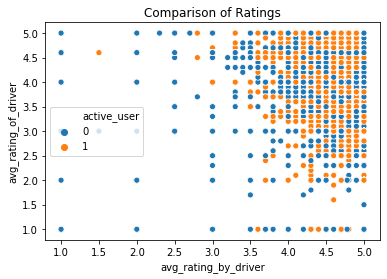

In [54]:
sns.scatterplot(ultimate_data_df.avg_rating_by_driver, ultimate_data_df.avg_rating_of_driver, \
           hue=ultimate_data_df.active_user)
plt.title('Comparison of Ratings')

The plot gives a visual analysis that in general, there are very few users retained who were given a rating of 3 or below by the driver

# Building a predictive model

In [56]:
ultimate_data_df.head(6)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,1,100.0,10.56,5.0,1


To begin with Random forest, we need to standardize values for the predictive model

In [57]:
#convert datetime values to days after min date value
last_trip_date_min = ultimate_data_df.last_trip_date.min()
signup_date_min = ultimate_data_df.signup_date.min()

In [58]:
# Convert the date into a number (of days since some point)

ultimate_data_df['last_trip_timedelta'] = (ultimate_data_df['last_trip_date'] - last_trip_date_min).dt.days.astype(int)
print(ultimate_data_df[['last_trip_date', 'last_trip_timedelta']].head())
ultimate_data_df.drop('last_trip_date', axis = 1, inplace = True)

  last_trip_date  last_trip_timedelta
0     2014-06-17                  167
1     2014-05-05                  124
2     2014-01-07                    6
3     2014-06-29                  179
4     2014-03-15                   73


In [59]:
ultimate_data_df['signup_timedelta'] = (ultimate_data_df['signup_date'] - signup_date_min).dt.days.astype(int)
print(ultimate_data_df[['signup_date', 'signup_timedelta']].head(6))
ultimate_data_df.drop('signup_date', axis = 1, inplace = True)

  signup_date  signup_timedelta
0  2014-01-25                24
1  2014-01-29                28
2  2014-01-06                 5
3  2014-01-10                 9
4  2014-01-27                26
5  2014-01-09                 8


In [60]:
ultimate_data_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,last_trip_timedelta,signup_timedelta
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,167,24
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,124,28
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,6,5
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,179,9
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,73,26


We can also analyse the 'city', 'phone' as catogorical data and check its dependencies

In [61]:
ultimate_data_df_enc = pd.get_dummies(ultimate_data_df, columns=['city', 'phone'], prefix=['city', 'phone'])

In [62]:
ultimate_data_df_enc.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,last_trip_timedelta,signup_timedelta,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,167,24,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,124,28,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,6,5,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,179,9,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,73,26,0,0,1,1,0


In [72]:
ultimate_data_df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int64  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active_user             50000 non-null  int64  
 9   last_trip_timedelta     50000 non-null  int64  
 10  signup_timedelta        50000 non-null  int64  
 11  city_Astapor            50000 non-null  uint8  
 12  city_King's Landing     50000 non-null  uint8  
 13  city_Winterfell         50000 non-null  uint8  
 14  phone_Android           50000 non-null

In [74]:
#select all columns EXCEPT the target variable column, which is active_user
#also remove last_trip_timedelta
cols = ultimate_data_df_enc.columns.tolist()
cols2 = cols[:8] + cols[10:]
cols2

['trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'ultimate_black_user',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'signup_timedelta',
 'city_Astapor',
 "city_King's Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone']

In [75]:
y = ultimate_data_df_enc['active_user']
X = ultimate_data_df_enc[cols2]

In [79]:
X[:8]

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_timedelta,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.700000,1.10,15.4,1,46.2,3.67,5.0,24,0,1,0,0,1
1,0,5.000000,1.00,0.0,0,50.0,8.26,5.0,28,1,0,0,1,0
2,3,4.300000,1.00,0.0,0,100.0,0.77,5.0,5,1,0,0,0,1
3,9,4.600000,1.14,20.0,1,80.0,2.36,4.9,9,0,1,0,0,1
4,14,4.400000,1.19,11.8,0,82.4,3.13,4.9,26,0,0,1,1,0
5,2,3.500000,1.00,0.0,1,100.0,10.56,5.0,8,0,0,1,0,1
6,1,4.601559,1.00,0.0,0,100.0,3.95,4.0,23,1,0,0,1,0
7,2,5.000000,1.00,0.0,0,100.0,2.04,5.0,27,0,0,1,0,1


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [82]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=27)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [83]:

y_pred=clf.predict(X_test)

In [84]:
# Model Accuracy, 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7676


In [85]:
#Important features
feature_imp = pd.Series(clf.feature_importances_,index=cols2).sort_values(ascending=False)
feature_imp

avg_dist                  0.209620
signup_timedelta          0.137284
weekday_pct               0.111989
avg_rating_by_driver      0.107657
surge_pct                 0.076205
trips_in_first_30_days    0.074692
avg_rating_of_driver      0.073188
avg_surge                 0.063216
city_King's Landing       0.046660
ultimate_black_user       0.032335
phone_Android             0.019284
phone_iPhone              0.017795
city_Astapor              0.017745
city_Winterfell           0.012330
dtype: float64

The avg_distance has the highest weight has the highest weight in the model

In [86]:
#Normalizing avg_dist
ultimate_data_df_enc['avg_dist'] = (ultimate_data_df_enc['avg_dist'] -(ultimate_data_df_enc['avg_dist']).min()) / np.ptp(ultimate_data_df_enc['avg_dist'])

In [87]:
ultimate_data_df_enc['avg_dist'][:5]

0    0.022801
1    0.051317
2    0.004784
3    0.014662
4    0.019446
Name: avg_dist, dtype: float64

In [88]:
#Adding a new variable to X
X = ultimate_data_df_enc[cols2]

In [89]:
#Repeating the model fitting and checking for accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [92]:
clf=RandomForestClassifier(n_estimators=100, random_state=27)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [93]:

y_pred=clf.predict(X_test)

In [94]:
print(f"Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(f"Confusion matrix: \n{metrics.confusion_matrix(y_test, y_pred)}")

Accuracy: 0.7676
Confusion matrix: 
[[6557 1196]
 [1709 3038]]


In [95]:
feature_imp = pd.Series(clf.feature_importances_,index=cols2).sort_values(ascending=False)
feature_imp

avg_dist                  0.209620
signup_timedelta          0.137284
weekday_pct               0.111989
avg_rating_by_driver      0.107657
surge_pct                 0.076205
trips_in_first_30_days    0.074692
avg_rating_of_driver      0.073188
avg_surge                 0.063216
city_King's Landing       0.046660
ultimate_black_user       0.032335
phone_Android             0.019284
phone_iPhone              0.017795
city_Astapor              0.017745
city_Winterfell           0.012330
dtype: float64

No handles with labels found to put in legend.


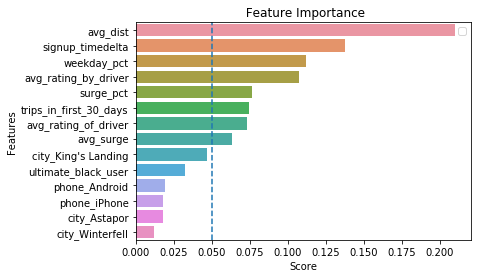

In [96]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title(" Feature Importance")
plt.axvline(0.05, linestyle='dashed')
plt.legend()

Text(0.5, 1.0, 'Two most heavily weighted factors')

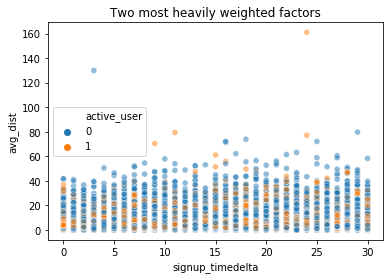

In [97]:
sns.scatterplot(ultimate_data_df.signup_timedelta, ultimate_data_df.avg_dist, \
               hue=ultimate_data_df.active_user, alpha=0.5)
plt.title('Two most heavily weighted factors')

The predictive model chosen was a random forest classifier. As it accepts both categorical and continuous variables, avoids the overfitting problem due to averaging individual predictions, and also has a good feature variable indicator. It is insensitive to the magnitude of the data, so normalizing or standardizing is not necessary. In fact, the 'avg_dist' columns above was normalized between different runs just to confirm, and the results were very similar.

Some caveats to consider include the imputed data for average ratings, and the type of cell phone used. This would be of more concern, however, if these features contributed higher importance to the model.

Ultimate might leverage these data to improve their long-term rider retention by encouraging new members to take longer trips in their first 30 days. It also appears as though users remain active longer when receiving better ratings from the drivers. Trips taken while the surge multiplier is > 1 is also to be encouraged.